In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_val_path = '../../data/images/Training/'
test_path = '../../data/images/Test/'

In [2]:
# preprocessing the images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range = 40,
                                        width_shift_range = 0.2,
                                        height_shift_range = 0.2,
                                        shear_range = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_val_path,
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(train_val_path,
                                                        target_size = (150, 150),
                                                        batch_size = 32,
                                                        class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_path,
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

Found 39375 images belonging to 2 classes.
Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [3]:
# inception model

from tensorflow.keras.applications import InceptionV3

conv_base = InceptionV3(weights = 'imagenet',
                        include_top = False,
                        input_shape = (150, 150, 3))

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [4]:
# freezing the base model

conv_base.trainable = False

# building the model

from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation = 'sigmoid'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 3

In [5]:
# compiling the model

from tensorflow.keras import optimizers

model.compile(loss = 'binary_crossentropy',
                optimizer = optimizers.legacy.RMSprop(learning_rate = 2e-5),
                metrics = ['acc'])

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss',
                                patience = 3,
                                restore_best_weights = True)

history = model.fit(train_generator,
                                steps_per_epoch = 100,
                                epochs = 30,
                                validation_data = validation_generator,
                                validation_steps = 50,
                                callbacks = [early_stopping])

# plotting the training and validation accuracy and loss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

Epoch 1/30


2023-07-23 19:17:49.380969: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.3182 - acc: 0.9300

2023-07-23 19:18:16.042715: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 38s 365ms/step - loss: 0.3182 - acc: 0.9300 - val_loss: 0.2886 - val_acc: 0.9463
Epoch 2/30
100/100 [==============================] - 33s 327ms/step - loss: 0.2011 - acc: 0.9566 - val_loss: 0.2428 - val_acc: 0.9525
Epoch 3/30
100/100 [==============================] - 33s 328ms/step - loss: 0.1857 - acc: 0.9581 - val_loss: 0.1972 - val_acc: 0.9606
Epoch 4/30
100/100 [==============================] - 34s 341ms/step - loss: 0.1582 - acc: 0.9650 - val_loss: 0.1702 - val_acc: 0.9656
Epoch 5/30
100/100 [==============================] - 34s 335ms/step - loss: 0.1457 - acc: 0.9659 - val_loss: 0.1504 - val_acc: 0.9688
Epoch 6/30
100/100 [==============================] - 34s 342ms/step - loss: 0.1201 - acc: 0.9756 - val_loss: 0.1320 - val_acc: 0.9737
Epoch 7/30
100/100 [==============================] - 34s 341ms/step - loss: 0.1302 - acc: 0.9650 - val_loss: 0.1380 - val_acc: 0.9688
Epoch 8/30
100/100 [==============================] - 34s 335ms/st

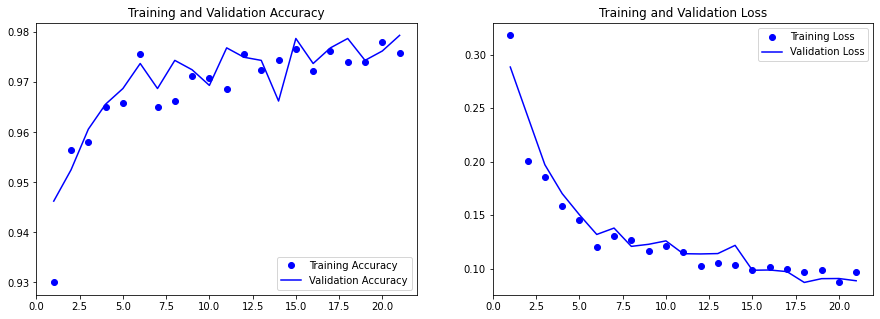

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(epochs, acc, 'bo', label = 'Training Accuracy')

ax[0].plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'bo', label = 'Training Loss')

ax[1].plot(epochs, val_loss, 'b', label = 'Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

plt.show()

In [8]:
test_loss, test_acc = model.evaluate(test_generator, steps = 50)

print('Test Accuracy:', test_acc)

2023-07-23 19:31:50.316366: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - 11s 217ms/step - loss: 0.6605 - acc: 0.6744
Test Accuracy: 0.6743749976158142


In [9]:
model.save('../../models/created_models/second_Inc_classifier.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
